##  Modeling the Impact of Stomatal Resistance Parameterizations on Total Evapotranspiration in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

One part of the Clark et al. (2015) study explored the impact of different stomatal resistance parameterizations on total evapotranspiration (ET) using a SUMMA model for the Reynolds Mountain East catchment. This study looked at three different stomatal resistance parameterizations: the simple soil resistance method, the Ball Berry method, and the Jarvis method.

In this Jupyter Notebook, the pySUMMA library is used to reproduce this analysis. First, the three different stomatal resistance parameterizations are described. Next, the Methods section describes how the pySUMMA can be used to create three different versions of the Reynolds Mountain East catchment model, one for each stomatal resistance parameterization. The Results section shows how to use pySUMMA and the Pandas library to reproduce Figure 7 from Clark et al. (2015). 

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library. 

## 2. Background

### The stomatal resistance parameterizations available in SUMMA

In [1]:
#import libraries to display equations within the notebook
from IPython.display import display, Math, Latex

### 1.) The simple soil resistance method

\begin{equation*}
r_{{s},{sun}} = r_{{s},{shd}} = \frac{r_{0c}}{\beta_v} \,\,\,\, 
\end{equation*}
$r_{0c} \,(s\,m^{-1})$ : the minimum stomatal resistance ,     ${\beta_v}\,(-)$ : the total soil water stress function

\begin{equation*}
{\beta_v} = \sum f_{{roots},{j}} \beta_{{v},{j}}  +  f_{roots}^{aq} \beta_{v}^{aq}
\end{equation*}
$z_{soil}$ : the soil depth, $f_{{roots},{j}}$ : the root density in the $j$-th soil layer
$\beta_{{v},{j}}$ : the water availability stress funtion in the $j$-th soil layer <br/>
$f_{roots}^{aq}$ : the fraction of roots for the aquifer, $\beta_{v}^{aq}$ : water availability stress function for the aquifer

For additional detail, see: https://github.com/DavidChoi76/pysumma/blob/master/simple1.png

### 2.) The Ball-Berry method
 

\begin{equation*}
g_i = v_t  \frac{A_i}{c_{air}}\frac{e_{air}}{e_{sat}(T_{veg})}P_{air} + g_{min}\beta_v, \,\,\,\,   i = sun, shd
\end{equation*}

$g_i\, (micromol \,\, m^{-2} s^{-1})$ : Stomatal conductance per unit sunlit and shaded leaf area <br/> 
$A_i\, (micromol \,\, m^{-2} s^{-1})$ : a function of the rate of photosynthesis <br/>
$c_{air}\, (Pa)$ : $CO_2$ concentration at the leaf surface (time varying model forcing, representing carbon fertilization) <br/>
$g_{min}\, (micromol \,\, m^{-2} s^{-1})$ : the minimum stomatal conductance <br/>
$v_t\,(-)$ : an empirical parameter to relate transpiration to the $CO_2$ flux, where a greater value of $v_t$ means the leaf consumes more water to produce the same carbon mass <br/>

For additinoal detail, see: https://github.com/DavidChoi76/pysumma/blob/master/BallBerry.png

### 3) The Jarvis method

\begin{equation*}
r_{{s},{i}} = \frac{r_{0c}}{f(Q_{{PAR},{i}})f(T_{air})f(e_{d})\beta_v} \,\,\,\,   i = sun, shd
\end{equation*}

the subscript $i$ defines either sunlit or shaded leaves <br/> 
$f(Q_{{PAR},{i}})$, $f(T_{air})$, $f(e_{d})$ : all limited to the range 0-1, represent the effects of photosynthetically-active radiation(PAR), air temperature, and vapor pressure deficit, where $ Q_{{PAR},{i}} $ represents PAR absorbed on sunlit or shaded leaves <br/> 

For additional detail, see: https://github.com/DavidChoi76/pysumma/blob/master/Jarvis.png

The above images are taken from the Stomal Resistance Method section within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [2]:
from ipyleaflet import Map, GeoJSON
import json

In [3]:
m = Map(center=[43.06745, -116.75489], zoom=15)
with open('reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[43.06745, -116.75489], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), GeoJSON(data={'type': 'FeatureCollection', 'name': 'reynolds_geojson_latlon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}, 'features': [{'type': 'Feature', 'properties': {'OBJECTID': 1, 'RCEW_REGIO': 376208.194027, 'PERIMETER': 3340.0, 'RMEAST_MAS': 2, 'RMEAST_M_1': 2, 'GRID_CODE': 1}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-116.7557156288284, 43.07072983625339], [-116.75559279969227, 43.07072957489522], [-116.75559315872648, 43.07063952502811], [-116.75547032977175, 43.07063926353894], [-116.75534750204696, 43.07063900192053], [-116.75522467432737, 43.07063873926983], [-116.7551018453776, 43.07063847738518], [-116.75510220512943, 43.0705484275199], [-116.75497937636112, 43.07054816550426], [-116.75497973629112, 43.070458115638395], [-116.75485690770425, 43.07045785349174], [-116.7547340803473, 43.07045759121584], [-116.754611252992, 43.070457328808125], [-116.75448842441011, 43.07045706626597], [-116.75436559706174, 43.070456802694125], [-116.75424276848315, 43.07045653988829], [-116.75424312949033, 43.070366490025975], [-116.75412030232148, 43.070366227091775], [-116.75399747392602, 43.0703659640231], [-116.75399783529119, 43.07027591416101], [-116.75387500707716, 43.07027565096134], [-116.7537521800931, 43.07027538763253], [-116.75362935188241, 43.07027512416918], [-116.75362971378532, 43.07018507430818], [-116.75363007445833, 43.07009502444305], [-116.75363043635795, 43.07000497457918], [-116.75363079702761, 43.06991492471125], [-116.75375362451547, 43.06991518907176], [-116.75375398500368, 43.06982513920156], [-116.75375434671845, 43.06973508933261], [-116.75375470720336, 43.06964503945952], [-116.75363188147955, 43.06964477600465], [-116.7536322421426, 43.069554726130995], [-116.75350941660027, 43.06955446254514], [-116.75350977744145, 43.06946441267091], [-116.75338695208056, 43.06946414895402], [-116.75338731309988, 43.0693740990792], [-116.75326448792045, 43.06937383523132], [-116.75326485034614, 43.06928378535855], [-116.75314202411995, 43.06928352137701], [-116.75301919912368, 43.069283257266314], [-116.75301956067906, 43.06919320739113], [-116.753019923461, 43.06910315751716], [-116.75289709759774, 43.069102893273666], [-116.7527742729644, 43.06910262890097], [-116.75277463610426, 43.06901257902725], [-116.75265181042415, 43.069012314520926], [-116.75265217374212, 43.06892226464661], [-116.75252934824346, 43.06892200000929], [-116.75252971173958, 43.06883195013435], [-116.7525300740058, 43.0687419002554], [-116.75240725009662, 43.068741635490554], [-116.75240761254095, 43.06865158561097], [-116.75240797621186, 43.06856153573259], [-116.75240833865288, 43.06847148585014], [-116.7524087023168, 43.06838143686942], [-116.75228587790387, 43.06838117107297], [-116.75228624174592, 43.068291122091665], [-116.7522866043617, 43.068201072205795], [-116.75228696820399, 43.06811102232113], [-116.75228733081644, 43.06802097243243], [-116.75228769465541, 43.067930922544896], [-116.75228805726088, 43.067840873553784], [-116.75228842109648, 43.06775082366344], [-116.75216559794013, 43.06775055864152], [-116.75216596195388, 43.06766050875055], [-116.75204313897898, 43.06766024359765], [-116.75192031723756, 43.067659977415076], [-116.7517974954942, 43.067659712001166], [-116.75167467252432, 43.06765944645277], [-116.75167503725551, 43.06756939656374], [-116.75167540075684, 43.067479346670616], [-116.75167576548104, 43.067389297679235], [-116.75167612897903, 43.06729924778324], [-116.75155330795809, 43.067298982109065], [-116.75155367163417, 43.06720893221254], [-116.75155403653679, 43.06711888231719], [-116.7515544002095, 43.06702883241775

### 2) Download TestCases from HS and Installation to prepare SUMMA simulation

In [4]:
# To authenticate using HTTP Basic authentication.
from hs_restclient import HydroShare, HydroShareAuthBasic

In [5]:
# import utils.py to download TestCases from HS, unzip and installation
from pysumma.utils import utils

In [53]:
# define directory where you save SUMMA TestCases
save_filepath = '/media/sf_pysumma'

In [6]:
# call install_test_cases_hs method to download TestCase from HS, unzip and install the TestCase.
hs_path = utils.install_test_cases_hs(save_filepath)

In [7]:
# Run this code to get to the path of the TestCase if it was gotten during a previous process
hs_path = save_filepath+'/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents'

### 3) Create pySUMMA Simulation Object

In [8]:
from pysumma.Simulation import Simulation

In [9]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S = Simulation(hs_path+'/summaTestCases_2.x/settings/wrrPaperTestCases/figure07/summa_fileManager_riparianAspenSimpleResistance.txt')

ModelOuput master file filepath: /media/sf_pysumma/pysumma/sopron_2018_notebooks/var_lookup.f90


In [10]:
# set the simulation start and finish times
S.decision_obj.simulStart.value = "2007-07-01 00:00"
S.decision_obj.simulFinsh.value = "2007-08-20 00:00"

### 4) Run SUMMA for the different stomatal resistance parameterization options with Developing version of Docker image

In [11]:
# query for the available stomatal resistance parameterizations
S.decision_obj.stomResist.options

['BallBerry', 'Jarvis', 'simpleResistance']

#### 4.1) assign simple soil resistance method 

In [12]:
S.decision_obj.stomResist.value = 'simpleResistance'
S.decision_obj.stomResist.value

'simpleResistance'

#### 4.2) set SUMMA executable file

In [13]:
S.executable = "/media/sf_pysumma/summa-master/bin/summa.exe"

#### 4.3) run the model giving the output the suffix "simpleResistance"

In [14]:
results_simpleResistance, out_file1 = S.execute(run_suffix="simpleResistance_hs", run_option = 'local')

file_suffix is 'simpleResistance_hs'.
file_master is '/media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure07/summa_fileManager_riparianAspenSimpleResistance.txt'.
start at 21:51:21
Name of Model Output control file: /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/meta/Model_Output.txt
decisions file =  /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure07/summa_zDecisions_riparianAspenSimpleResistance.txt
   1 simulStart: 2007-07-01 00:00
   2 simulFinsh: 2007-08-20 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: simpleResistance
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: specified
  10 f_Richards: mixdform
  11 groundwatr: noXplict
  12 hc_pr

#### 4.4) repeat for the Ball Berry method 

In [15]:
S.decision_obj.stomResist.value = 'BallBerry'
S.decision_obj.stomResist.value

'BallBerry'

In [16]:
results_BallBerry, out_file2 = S.execute(run_suffix="BallBerry_hs", run_option = 'local')

file_suffix is 'BallBerry_hs'.
file_master is '/media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure07/summa_fileManager_riparianAspenSimpleResistance.txt'.
start at 21:51:28
Name of Model Output control file: /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/meta/Model_Output.txt
decisions file =  /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure07/summa_zDecisions_riparianAspenSimpleResistance.txt
   1 simulStart: 2007-07-01 00:00
   2 simulFinsh: 2007-08-20 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: specified
  10 f_Richards: mixdform
  11 groundwatr: noXplict
  12 hc_profile: constan

#### 4.5) repeat for the Jarvis method 

In [17]:
S.decision_obj.stomResist.value = 'Jarvis'
S.decision_obj.stomResist.value

'Jarvis'

In [18]:
results_Jarvis, out_file3 = S.execute(run_suffix="Jarvis_hs", run_option = 'local')

file_suffix is 'Jarvis_hs'.
file_master is '/media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure07/summa_fileManager_riparianAspenSimpleResistance.txt'.
start at 21:51:31
Name of Model Output control file: /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/meta/Model_Output.txt
decisions file =  /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure07/summa_zDecisions_riparianAspenSimpleResistance.txt
   1 simulStart: 2007-07-01 00:00
   2 simulFinsh: 2007-08-20 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: Jarvis
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: specified
  10 f_Richards: mixdform
  11 groundwatr: noXplict
  12 hc_profile: constant
  13

## 4. Results

### Recreate the Figure 7 plot from Clark et al., 2015: The total ET for the three different stomatal resistance methods

In [19]:
from pysumma.Plotting import Plotting
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import pandas as pd
jtplot.figsize(x=10, y=10)

#### 4.1) Create function to calculate Total ET from SUMMA output

In [20]:
def calc_total_et(et_output_df):
    # Total Evapotranspiration = Canopy Transpiration + Canopy Evaporation + Ground Evaporation
    # Change unit from kgm-2s-1 to mm/hr (mulpitle 3600)
    total_et_data = (et_output_df['scalarCanopyTranspiration'] + et_output_df['scalarCanopyEvaporation'] + et_output_df['scalarGroundEvaporation'])*3600
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2007-06-01":"2007-08-20"]
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df.resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    return total_et_by_hour

#### 4.2) Get hour of day output of the three stomatal resistance methods for the period 1 June to 20 August 2007

In [21]:
simResis_hour = calc_total_et(results_simpleResistance)
BallBerry_hour = calc_total_et(results_BallBerry)
Jarvis_hour = calc_total_et(results_Jarvis)

#### 4.3) Combine the stomatal resistance parameterizations into a single Pandas Dataframe

In [22]:
# Combine each stomatal resistance parameterizations
ET_Combine = pd.concat([BallBerry_hour, Jarvis_hour, simResis_hour], axis=1)
# add label 
ET_Combine.columns = ['Ball-Berry', 'Jarvis', 'Simple resistance']

In [23]:
ET_Combine

,Ball-Berry,Jarvis,Simple resistance
0,-0.019581,-0.018791,-0.060225
1,-0.017494,-0.016711,-0.060183
2,-0.013667,-0.013033,-0.063893
3,-0.011339,-0.010732,-0.061104
4,-0.011094,-0.010473,-0.049029
5,-0.011009,-0.010342,-0.049239
6,-0.010935,-0.011686,-0.043813
7,-0.048063,-0.055936,-0.057363
8,-0.122850,-0.131118,-0.108637
9,-0.193189,-0.211725,-0.170653


#### 4.4) Add obervation data from Aspen station and Reynolds Mountain East to the plot

In [25]:
# create pySUMMA Plotting Object
Val_eddyFlux = Plotting(hs_path+'/summaTestCases_2.x/testCases_data/validationData/ReynoldsCreek_eddyFlux.nc')

In [33]:
# read Total Evapotranspiration(LE-wpl) from validation netcdf file
Obs_Evapotranspitaton = Val_eddyFlux.ds['LE-wpl']
# create dates(X-axis) attribute from validation netcdf file
dates = Obs_Evapotranspitaton.coords['time'].data
# Change unit from Wm-2 to mm/hr (1 Wm-2 = 0.0864 MJm-2day-1, 1 MJm-2day-1 = 0.408 mmday-1, 1day = 24h)
data_values = Obs_Evapotranspitaton.data*0.0864*0.408/24*1.43
# create two dimensional tabular data structure 
df = pd.DataFrame(data_values, index=dates)
# set the time period to display plot
df_filt = df.loc["2007-06-01":"2007-08-20"]
# select aspen obervation station among three different stations
df_filt.columns = ['-','Observation (aspen)','-']
# resample data by the average for hour of day
df_gp_hr = df_filt.groupby([df_filt.index.hour, df_filt.index.minute]).mean()
# reset index so each row has an hour an minute column
df_gp_hr.reset_index(inplace=True)
# add hour and minute columns for plotting
xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

#### 4.5) Plotting output of three different stomatal resistance parameterizations and observation data

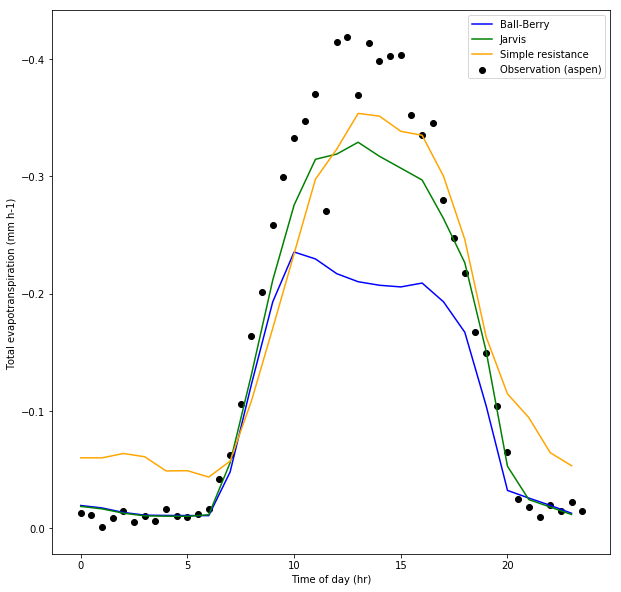

In [46]:
# create plot with three different stomatal resistance parameterizations
ET_Combine_Graph = ET_Combine.plot(color=['blue', 'green', 'orange'])
# invert y axis
ET_Combine_Graph.invert_yaxis()
# plot scatter with x='xvals', y='Observation (aspen)'
ET_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black')
# add x, y label
ET_Combine_Graph.set(xlabel='Time of day (hr)', ylabel='Total evapotranspiration (mm h-1) ')
# show up the legend
ET_Combine_Graph.legend()
jtplot.figsize(x=10, y=10)

## 5. Discussion

As stated in Clark et al., 2015, the following insights can be gained from this analysis:
* The simulations in Figure 7 illustrate substantial differences in the estimates of the diurnal cycle of transpiration depending on the choice of stomatal resistance parameterization. 
* The simple soil resistance parameterization [Liang et al., 1994], when combined with the two-source model of within-canopy and below-canopy turbulence [Choudhury and Monteith, 1988; Clark et al., 2015a], results in a substantial amount of transpiration at night when there is no light available for photosynthesis. 
* The physiological representations of transpiration – using the Jarvis and Ball-Berry parameterizations, as defined in Clark et al. [2015a] – have an explicit dependence on photosynthetically active radiation and show the expected result of zero transpiration during nighttime hours. This results in a poor match with observations (Figure 7).
* A striking result from Figure 7 is that the Ball-Berry parameterization underestimates evapotranspiration when applied using the default model parameters for stomatal resistance in combination with the particular choice of process parameterizations and parameters for soil hydrology.

## 6. Post notebook and simulation results back to Hydroshare

In [47]:
from pysumma.hydroshare import hydroshare
hs = hydroshare.hydroshare()


The hs_utils library requires a secure connection to your HydroShare account.
Please enter your HydroShare username: choi
Enter the HydroShare password for user 'choi': ········
Successfully established a connection with HydroShare


In [49]:
# write meta data such as abstract, title, keywords, rtype
abstract = 'output of SUMMA(Fig7)'
title = 'output of SUMMA(Fig7)'
keywords = ('SUMMA', 'Hydrologic Model')
rtype = 'GenericResource'
files = out_file1, out_file2, out_file3
metadata = '[{"creator":{"name":"Youngdon Choi"}}, {"creator":{"name":"Jeffrey Sadler"}}]'
extra_metadata = '{"key-1": "value-1", "key-2": "value-2"}'

In [50]:
# post simulation results of simpleResistance back to HS
resource_id = hs.createHydroShareResource(title=title, content_files=files, keywords=keywords, abstract=abstract, resource_type='genericresource', public=False)

Resource Created Successfully                           
Successfully Added Content Files                      


#### Save this notebook file and add the notebook to the resource

In [56]:
# add a notebook to the resource of summa output
npath = save_filepath+'/pysumma/sopron_2018_notebooks/pySUMMA_Demo_Example_Fig7_Using_TestCase_from_Hydroshare.ipynb'
# check the resource id on HS that created.
hs.addContentToExistingResource(resource_id, [npath])

Successfully Added Content Files                      


## 7. make this resource public

In [79]:
# check the resource id 
C_resource_id = 'be3acc6022444a57b96915fb3b00a8c3'

In [80]:
# make a resource public
hs.setAccessRules(C_resource_id, public=True)

'14fd805b092d49218e7ff88105447fbf'